<a href="https://www.kaggle.com/code/sofiamatias/icecube-predictions?scriptVersionId=123961033" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Concepts and ideas

## How zenith and azimuth gives a direction
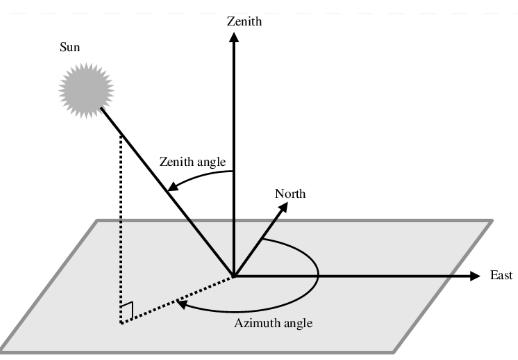

# Merge Data

In [5]:
def get_test_df_from_a_batch (test_batch_df, sensors_df, test_meta_df, batch_number):
    """
    Converts test_batch, test_meta and sensor_geometry into a 'test_df' dataframe containing features and targets
    It filters 'auxiliary' field to only 'False' values, due to challenge explanation:
    ' If True, the pulse was not fully digitized, is of lower quality, and was more likely to originate from noise.'
    It uses polars dataframes only.
    """
    test_batch_df = test_batch_df.filter(pl.col("auxiliary") == False)
    sensors_df = sensors_df.with_columns(pl.col('sensor_id').cast(pl.Int16, strict=False))
    test_df = test_batch_df.join (sensors_df, how='left', on = 'sensor_id')
    test_meta_batch_df = test_meta_df.filter(pl.col("batch_id") == batch_number)
    test_df = test_df.join (test_meta_batch_df, how='left', on = 'event_id')
    test_df = test_df.drop (columns=['batch_id', 'auxiliary'])
    test_df = test_df.drop (columns=['sensor_id', 'first_pulse_index', 'last_pulse_index'])
    del test_meta_batch_df #memory
    del test_batch_df #memory
    print (f'\nTest dataframe:\n')
    print (test_df)
    return test_df

# Predictions function

In [37]:
def predictions (x_test_df, device):
    """
    Predicts zenith (model_ze) and azimuth (model_az).
    Parameters:
    x_test - test set features
    Output:
    az_preds, ze_preds
    """   
    from tqdm import tqdm
    
    az_preds_list = []
    ze_preds_list = []
    num_rows = 400000

    # Initializing models
    print ('Initialize model for zenith...\n')
    if len(saved_model_ze_path) != 0:
        model_ze = lgb.Booster (params = {'device': device}, model_file = saved_model_ze_path)
    else:
        print (f"model_ze does not exist. Aborting predictions.\n")
        return -1, -1
    print ('\nInitialize model for azimuth...\n')
    if len(saved_model_az_path) != 0:
        model_az = lgb.Booster(params = {'device': device}, model_file = saved_model_az_path)
    else:
        print (f"model_az does not exist. Aborting predictions.\n")
        return -1, -1

    print ('\nPredict values...\n')
    print (model_ze.params)
    #model_ze_fast = convert(model_ze, 'pytorch')
    #model_ze_fast.to('cuda')
    events = x_test_df['event_id'].unique()[:100]
    for event in tqdm (events):
        x_test = test_df.filter(pl.col("event_id") == event)
        ze_preds = model_ze.predict (x_test.to_numpy())
        ze_preds_list.append (ze_preds)

        x_test2 = np.vstack ([x_test, ze_preds]).transpose()
        gc.collect()
        #model_az_fast = convert(model_az, 'pytorch')
        #model_az_fast.to('cuda')
        az_preds = model_az.predict (x_test2)
        az_preds_list.append (az_preds)
    
    return az_preds_list, ze_preds_list

# Model train

## Imports

In [30]:
#%%time
#!pip install /kaggle/input/hummingbird-ml-package/joblib-1.2.0-py3-none-any.whl
#!pip install /kaggle/input/hummingbird-ml-package/onnxconverter_common-1.13.0-py2.py3-none-any.whl
#!pip install /kaggle/input/hummingbird-ml-package/hummingbird_ml-0.4.4-py2.py3-none-any.whl
#print ('Finished installing hurmingbird.')

In [31]:
%%time
#from hummingbird.ml import convert
import polars as pl
import numpy as np
import pandas as pd
import os, gc

import lightgbm as lgb
from torch import cuda

print ('\nFinished loading imports.\n')

if cuda.is_available():
    import cudf
    device = 'gpu'
else:
    device = 'cpu'
    
print (f"Device for predictions is {device}.\n")

scores_df = pd.DataFrame([]) 
input_path = '/kaggle/input/'
work_path = '/kaggle/working/'
scores_path = f'{work_path}scores.csv'
saved_model_az_path = ''
saved_model_ze_path = ''


Finished loading imports.

Device for predictions is cpu.

CPU times: user 573 µs, sys: 0 ns, total: 573 µs
Wall time: 555 µs


## Load data

In [32]:
%%time
print ('Loading files...')
for dirname, _, filenames in os.walk(input_path):
    for filename in filenames:
        filepath = os.path.join(dirname, filename)
        if 'model_az' in filepath:
            saved_model_az_path = filepath
            print ("'model_az' path loaded.")
        elif 'model_ze' in filepath:
            saved_model_ze_path = filepath
            print ("'model_ze' path loaded.")
        elif 'score' in filepath:
            scores_df = pl.read_csv (filepath).to_pandas()
            print ("'scores' file loaded.")
        elif 'sensor' in filepath:
            sensors_df = pl.read_csv (filepath).lazy()
            print ("'sensor_geometry' file loaded.")
        elif 'test_meta' in filepath:
            test_meta_filepath = filepath
            print ("'test_meta' file path found and loaded.")

Loading files...
'scores' file loaded.
'model_az' path loaded.
'model_ze' path loaded.
'test_meta' file path found and loaded.
'sensor_geometry' file loaded.
CPU times: user 10.5 ms, sys: 9.9 ms, total: 20.4 ms
Wall time: 20.5 ms


In [38]:
%%time
# 9mins per batch if I feed the entire batch all at once. RAM runs out after a few batches.
print ('Starting predictions...\n')

submission_df = pl.DataFrame([])
counts = 1
for dirname, _, filenames in os.walk(input_path):
    for filename in filenames:
        filepath = os.path.join(dirname, filename)
        if ('batch' in filepath) and ('train' in dirname):
            test_meta_df = pl.read_parquet (test_meta_filepath).lazy()
            print ("'test_meta' file loaded.")
            test_batch_df = pl.read_parquet (filepath).lazy()
            print (f"\nLoading 'test_batch' file.\n")
            print (test_batch_df.collect())
            batch_number = int (filename.split('_')[1].split('.')[0])
            print (f"'test_batch_{batch_number}' file loaded.\n")
            print (f"\n\nPredicting values for batch id {batch_number} - batch {counts}\n\n")
            test_df = get_test_df_from_a_batch (test_batch_df.collect(), 
                                                 sensors_df.collect(), 
                                                 test_meta_df.collect(), 
                                                 batch_number)
            del test_batch_df #memory
            del test_meta_df #memory
            az_pred, ze_pred = predictions (test_df, device)
            print ('Azimuth predictions:\n', az_pred)
            print ('Zenith predictions:\n', ze_pred)
            if type(az_pred) == int:
                print ('Predictions are not valid. Skipping these values and continuing with next batch.')
                break
            batch_results = {'event_id': test_df['event_id'], 'azimuth': az_pred, 'zenith': ze_pred}
            del test_df #memory
            batch_results_df = pl.DataFrame (batch_results).lazy()
            batch_results_df = batch_results_df.groupby('event_id').median()
            if len(submission_df) == 0:
                submission_df = batch_results_df
            else:
                submission_df = pl.concat (submission_df, batch_results_df)
            del batch_results_df
            gc.collect()
            counts += 1 
            if count == 6:
                break

Starting predictions...

'test_meta' file loaded.

Loading 'test_batch' file.

shape: (32801416, 5)
┌───────────┬───────┬────────┬───────────┬───────────┐
│ sensor_id ┆ time  ┆ charge ┆ auxiliary ┆ event_id  │
│ ---       ┆ ---   ┆ ---    ┆ ---       ┆ ---       │
│ i16       ┆ i64   ┆ f64    ┆ bool      ┆ i64       │
╞═══════════╪═══════╪════════╪═══════════╪═══════════╡
│ 2024      ┆ 6029  ┆ 1.425  ┆ true      ┆ 777938857 │
│ 2371      ┆ 6078  ┆ 1.475  ┆ true      ┆ 777938857 │
│ 920       ┆ 6508  ┆ 0.425  ┆ true      ┆ 777938857 │
│ 4872      ┆ 7886  ┆ 0.475  ┆ true      ┆ 777938857 │
│ …         ┆ …     ┆ …      ┆ …         ┆ …         │
│ 1626      ┆ 27878 ┆ 0.275  ┆ true      ┆ 781200050 │
│ 4818      ┆ 28174 ┆ 1.425  ┆ true      ┆ 781200050 │
│ 1145      ┆ 28206 ┆ 0.975  ┆ true      ┆ 781200050 │
│ 2927      ┆ 28652 ┆ 0.675  ┆ true      ┆ 781200050 │
└───────────┴───────┴────────┴───────────┴───────────┘
'test_batch_240' file loaded.



Predicting values for batch id 240 - batch

100%|██████████| 100/100 [00:36<00:00,  2.71it/s]


Azimuth predictions:
 [array([3.79654985, 4.59267505, 5.66682567, 5.66771522, 5.36838135,
       5.2109707 , 4.93214991, 5.01833682, 4.53481943, 5.41213505,
       5.68960619, 5.12605258, 3.26510388, 4.14124395, 4.81392634,
       4.30680204, 4.17813576, 4.71177613, 3.11304213, 4.91344814,
       4.85915957, 4.0994433 , 4.20536849, 3.99634172, 5.10314991,
       2.46843617, 3.1899547 ]), array([5.22270465, 5.12322932, 3.78848126, 3.39407213, 3.36545028,
       3.08964027, 3.25567303, 3.56506419, 3.35476799, 2.91978273,
       3.28124251, 3.30342035, 2.73299462, 2.93054212, 2.76872596,
       2.46959609, 2.18967933, 2.26081832, 2.25711958, 3.28965871,
       2.29537434, 2.6805022 , 3.00666157, 3.56336402]), array([1.8558408 , 1.53172839, 2.0425081 , 2.62246726, 2.28586392,
       2.46524702, 2.76193367, 2.49878014, 3.63499664, 4.44619467]), array([2.57666692, 3.2288224 , 4.28687428, 3.55874588, 3.17484261,
       5.6514024 , 4.70619627, 4.8607823 , 4.60554583]), array([2.84069971, 2.980

ShapeError: could not create a new dataframe: series "event_id" has length 23567471 while series "azimuth" has length 100

# Submissions

In [7]:
submission_df['azimuth'] = submission_df['azimuth'].apply (lambda x: 2*np.pi if x > 2*np.pi else x)
submission_df['zenith'] = submission_df['zenith'].apply (lambda x: np.pi if x > np.pi else x)
submission_df.to_csv (f'{work_path}submission.csv', index=False)

ColumnNotFoundError: azimuth